# Convolutional Neural Networks

_Life can only be understood backwards; but it must be lived forwards._ - Søren Kierkegaard

Concepts
- Temporal Convolutional Net (TCN)
- Vector Autoregression

TODO
- either TCN/VAR of all the series, of the PCE components, or most popular
  or representative


In [23]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torchinfo
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from finds.structured import BusDay
from finds.readers import Alfred
from secret import credentials
# %matplotlib qt
VERBOSE = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
# train-test split date
split_date = '2021-12-01'   # training period up to this date

In [25]:
# up to max number p of VAR(p) lags
maxlags = 6

In [26]:
alf = Alfred(api_key=credentials['fred']['api_key'], verbose=-1)
vspans = alf.date_spans('USREC')    # recession periods for plots

In [27]:
# CPI for U.S. City Average: Monthly, Seasonally Adjusted
# https://fred.stlouisfed.org/release/tables?rid=10&eid=34483
# 'CUSR0000SEEA'
series_ids = ['CPIFABSL', 'CPIHOSSL', 'CPIAPPSL', 'CPITRNSL', 'CPIMEDSL', 'CPIOGSSL']
df = pd.concat([alf(s, log=1, diff=1) for s in series_ids], axis=1)\
       .dropna()\
       .sort_index()
df.index = BusDay.to_datetime(df.index)
df.index.freq = 'M'     # set index to datetime type and freq = 'M'

/tmp/ipykernel_602057/4272565358.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.index.freq = 'M'     # set index to datetime type and freq = 'M'


In [28]:
names = [s[s.find(':')+2:s.find(' in ')] for s in alf.header(series_ids)]
names

['Food and Beverages',
 'Housing',
 'Apparel',
 'Transportation',
 'Medical Care',
 'Other Goods and Services']

In [29]:
# Standardize the data data
scaler = StandardScaler().fit(df)
scaled_data = DataFrame(scaler.transform(df), columns=names, index=df.index)
scaled_data

,Food and Beverages,Housing,Apparel,Transportation,Medical Care,Other Goods and Services
date,,,,,,
1967-02-28,-1.514294,-1.123374,0.528419,0.262158,-0.260945,-1.020565
1967-03-31,-0.803761,-1.123374,0.117546,-0.270473,-0.265522,-0.290026
1967-04-30,-1.516345,-0.064928,0.523552,0.258920,0.977131,-1.020565
1967-05-31,-0.803761,-0.068382,0.115127,-0.006978,-0.279054,-0.292134
1967-06-30,1.327849,-1.123374,0.518742,-0.270473,0.950357,-0.294231
...,...,...,...,...,...,...
2023-12-31,-0.305673,-0.150090,-0.300364,-0.226813,-0.199913,-0.950240
2024-01-31,0.136279,0.874513,-1.728819,-0.823810,0.045640,0.340696
2024-02-29,-0.763532,0.154003,0.841913,0.932892,-1.610667,-1.786460


In [30]:
ntrain = sum(scaled_data.index < split_date)
M = scaled_data.shape[1]      # M is number of time series

## Temporal Convolutional Net (TCN)

- convolution as a filter such as a weighted average
- hyperparameters: 
  - dropout
  - hidden layers and size
  - batch size and shuffling

TODO:
- example of 1D 2-channel and weighted average



In [31]:
class TCN(torch.nn.Module):
    class CausalConv1dBlock(torch.nn.Module):
        """Conv1d block with ReLU, skip, dropout, dilation and padding"""
        
        def __init__(self, in_channels, out_channels, kernel_size, dilation,
                     dropout):
            super().__init__()

            # print('kernel', kernel_size, 'dilation', dilation)
            self.network = torch.nn.Sequential(
                torch.nn.ConstantPad1d(((kernel_size-1)*dilation, 0), 0),
                torch.nn.Conv1d(in_channels, out_channels, kernel_size,
                                dilation=dilation),
                torch.nn.ReLU(),
                torch.nn.ConstantPad1d(((kernel_size-1)*dilation, 0), 0),
                torch.nn.Conv1d(out_channels, out_channels, kernel_size,
                                dilation=dilation),
                torch.nn.ReLU(),
                torch.nn.Dropout(dropout))
            self.skip = lambda x: x
            if in_channels != out_channels:   # downsample for skip if necessary
                self.skip = torch.nn.Conv1d(in_channels, out_channels, 1)

        def forward(self, x):
            return self.network(x) + self.skip(x)  # with skip connection


    def __init__(self, n_features, blocks, kernel_size, dropout):
        """TCN model by connecting multiple convolution layers"""
        super().__init__()
        in_channels = n_features
        L = []
        for dilation, hidden in enumerate(blocks):
            L.append(self.CausalConv1dBlock(in_channels=in_channels,
                                            out_channels=hidden,
                                            kernel_size=kernel_size,
                                            dilation=2**dilation,
                                            dropout=dropout))
            in_channels = hidden
        self.network = torch.nn.Sequential(*L) if L else lambda x: x
        if L:
            self.classifier = torch.nn.Conv1d(in_channels, n_features, 1)
        else:
            self.classifier = torch.nn.Sequential(
                torch.nn.ConstantPad1d((kernel_size-1, 0), 0),                
                torch.nn.Conv1d(in_channels, n_features, kernel_size))

    def forward(self, x):
        """input is (B, n_features, L)), linear expects (B, * n_features)"""
        return self.classifier(self.network(x))

    def save(self, filename):
        """save model state to filename"""
        return torch.save(self.state_dict(), filename)

    def load(self, filename):
        """load model name from filename"""
        self.load_state_dict(torch.load(filename, map_location='cpu'))
        return self

In [32]:
# Model training parameters
seq_len = 8         # length of each input sequence for TCN
batch_size = 16
step_size = 100     # learning rate scheduler step size
lr = 0.01           # initial learning rate
num_lr = 3
num_epochs = step_size * num_lr
results = {}        # to collect evaluate results
train_loss = {}

In [33]:
# Form input data from training set
n_features = scaled_data.shape[1]    # number of input planes
train_exs = [scaled_data.iloc[(i - seq_len):(i + 1)].values
             for i in range(seq_len, ntrain)]

Train a 1D Convolution Model


In [34]:
model = torch.nn.Conv1d(n_features, n_features, kernel_size=1).to(device)
print(model)
print(torchinfo.summary(model))
modelname = "1D-Convolution"
train_loss[modelname] = []
optimizer = torch.optim.Adam(model.parameters())
loss_function = nn.MSELoss()

Conv1d(6, 6, kernel_size=(1,), stride=(1,))
Layer (type:depth-idx)                   Param #
Conv1d                                   42
Total params: 42
Trainable params: 42
Non-trainable params: 0


In [35]:
# train_ex should have dimension (batch size, channels, sequence length+1)
train_ex = torch.tensor(scaled_data.values[:ntrain].T)[None,:,:].float().to(device)

In [36]:
for epoch in range(num_epochs):
    for _ in range(batch_size):
        total_loss = 0.0
        model.train()
        model.zero_grad()
        X = train_ex[:,:,:-1]
        Y = train_ex[:,:,1:]
        output = model(X)
        loss = loss_function(output, Y)  # calculated over all outputs
        total_loss += float(loss)
        loss.backward()
        optimizer.step()

        model.eval()
    train_loss[modelname].append(total_loss)
    
    X = torch.tensor(scaled_data.values.T)[None,:,:].float().to(device)
    pred = model(X).cpu().detach().numpy()[0,:,:].T
    results[modelname] = {
        'Train Error': mean_squared_error(scaled_data.values[1:ntrain],
                                          pred[:ntrain-1]),
        'Test Error': mean_squared_error(scaled_data.values[ntrain:],
                                         pred[ntrain-1:-1])
    }

In [37]:
conv1d_weights = np.vstack([model.bias.cpu().detach().numpy(),
                            model.weight.cpu().detach().numpy()[:,:,0].T])

Fit TCN models


In [56]:
for block, kernel_size, dropout in [[1,1,0], [1,2,0], [2,1,0], [2,2,0],
                                    [1,1,0.5], [1,2,0.5], [2,1,0.5], [2,2,0.5]]:
    modelname = f"TCN(b={block},k={kernel_size},d={dropout:.1f})"
    train_loss[modelname] = []

    # Set model, optimizer, loss function and learning rate scheduler
    model = TCN(n_features=n_features, 
                blocks=[n_features]*block,
                kernel_size=kernel_size,
                dropout=dropout).to(device)
    print()
    print('******', modelname, '******')
    print(model)
    print(torchinfo.summary(model))

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, gamma=0.1, step_size=step_size
    )
    loss_function = nn.MSELoss()

    # Run training loop over num_epochs with batch_size
    num_epochs = step_size * num_lr
    for epoch in range(num_epochs):

        # shuffle indxs into batches
        idxs = np.arange(len(train_exs))
        random.shuffle(idxs)
        batches = [idxs[i:min(len(idxs), i + batch_size)]
                   for i in range(0, len(idxs), batch_size)]

        # train by batch
        total_loss = 0.0
        model.train()
        for batch in batches:
            # input has shape (batch_size, n_features, seq_len)
            # Creating a tensor from a list of numpy.ndarrays is extremely slow.
            nparray = np.array([[train_exs[idx][seq] for idx in batch]
                                for seq in range(seq_len+1)])
            train_ex = torch.tensor(nparray).permute(1, 2, 0).float().to(device)
            model.zero_grad()
            X = train_ex[:,:,:-1]
            Y = train_ex[:,:,1:]
            output = model(X)
            loss = loss_function(output, Y)  # calculated over all outputs
            total_loss += float(loss) / len(batches)
            loss.backward()
            optimizer.step()
            scheduler.step()

        model.eval()
        train_loss[modelname].append(total_loss)
        if VERBOSE and (epoch % (step_size//2)) == 0:
            print(epoch, num_epochs, optimizer.param_groups[0]['lr'], total_loss)

        # Compute MSE of one-period ahead forecast error in train and test sets
        X = torch.tensor(scaled_data.values.T)[None,:,:].float().to(device)
        pred = model(X).cpu().detach().numpy()[0,:,:].T
        results[modelname] = {
            'Train Error': mean_squared_error(scaled_data.values[1:ntrain],
                                              pred[:ntrain-1]),
            'Test Error': mean_squared_error(scaled_data.values[ntrain:],
                                             pred[ntrain-1:-1])
        }
        #print('Blocks:', block, 'Kernel size:', kernel_size, results[modelname])
        #print(pd.concat(res, axis=1).T)


****** TCN(b=1,k=1,d=0.0) ******
TCN(
  (network): Sequential(
    (0): CausalConv1dBlock(
      (network): Sequential(
        (0): ConstantPad1d(padding=(0, 0), value=0)
        (1): Conv1d(6, 6, kernel_size=(1,), stride=(1,))
        (2): ReLU()
        (3): ConstantPad1d(padding=(0, 0), value=0)
        (4): Conv1d(6, 6, kernel_size=(1,), stride=(1,))
        (5): ReLU()
        (6): Dropout(p=0, inplace=False)
      )
    )
  )
  (classifier): Conv1d(6, 6, kernel_size=(1,), stride=(1,))
)
Layer (type:depth-idx)                   Param #
TCN                                      --
├─Sequential: 1-1                        --
│    └─CausalConv1dBlock: 2-1            --
│    │    └─Sequential: 3-1              84
├─Conv1d: 1-2                            42
Total params: 126
Trainable params: 126
Non-trainable params: 0

****** TCN(b=1,k=2,d=0.0) ******
TCN(
  (network): Sequential(
    (0): CausalConv1dBlock(
      (network): Sequential(
        (0): ConstantPad1d(padding=(1, 0), val

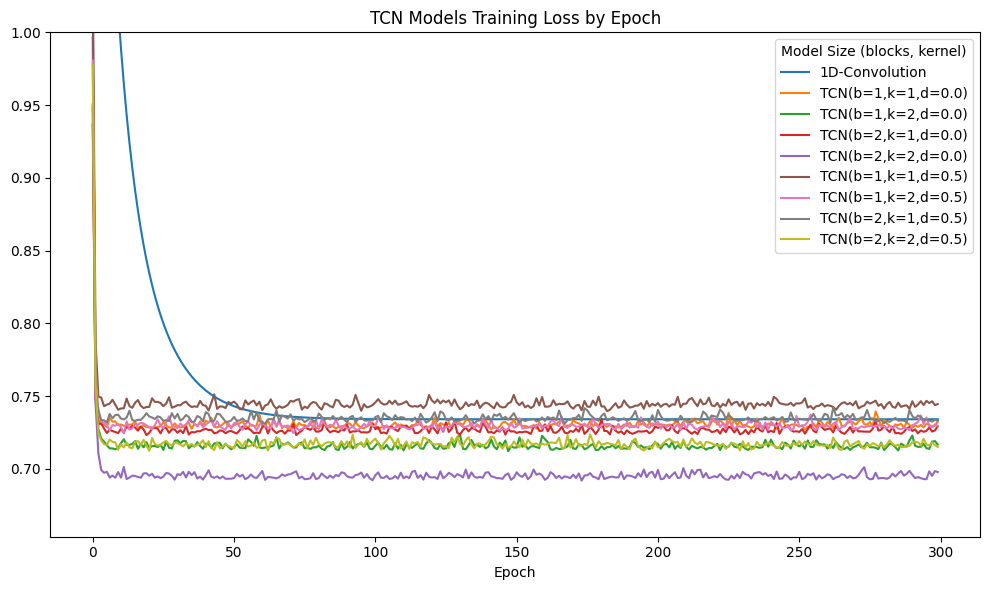

In [39]:
fig, ax = plt.subplots(figsize=(10, 6))
DataFrame(train_loss).plot(ax=ax)
ax.set_ylim(top=1.0)
ax.set_title(f"TCN Models Training Loss by Epoch")
ax.set_xlabel('Epoch')
ax.legend(title='Model Size (blocks, kernel)')
plt.tight_layout()

In [54]:
print('Sorted by Test Error')
DataFrame(results).T.sort_values('Test Error')

Sorted by Test Error


,Train Error,Test Error
"TCN(b=2,k=1,d=0.5)",0.730975,0.797471
1D-Convolution,0.734049,0.804834
"TCN(b=1,k=1,d=0.0)",0.730197,0.823324
"TCN(b=2,k=2,d=0.5)",0.703123,0.825678
"TCN(b=1,k=2,d=0.5)",0.716962,0.852393
"TCN(b=1,k=1,d=0.5)",0.735571,0.865943
"TCN(b=1,k=2,d=0.0)",0.708393,0.877891
"TCN(b=2,k=1,d=0.0)",0.726959,0.881181
"TCN(b=2,k=2,d=0.0)",0.706048,0.932908


## Vector Autoregression

predict multiple time series (of the extracted approximate factors)
- vector autoregression as a weighted moving average


In [41]:
var_model = VAR(scaled_data.iloc[:ntrain], freq='ME')

### Lag order

The lagged coefficients estimated from the Vector Autoregression produce a 
multi-period cumulative forecast 


In [42]:
print("Optimal number of VAR(p) lags selected by various IC")
DataFrame({ic: var_model.fit(maxlags=maxlags, ic=ic).k_ar
           for ic in ['aic', 'fpe', 'hqic', 'bic']},
          index=['optimal p:'])\
          .rename_axis(columns='IC:')

Optimal number of VAR(p) lags selected by various IC


IC:,aic,fpe,hqic,bic
optimal p:,3,3,2,2


In [43]:
# Fit VAR(p) models
var_models = {p: var_model.fit(p) for p in range(1, maxlags+1)} # fit models

In [51]:
# Show model summary for VAR(1)
print(var_models[1].summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 27, May, 2024
Time:                     14:50:03
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -1.69952
Nobs:                     657.000    HQIC:                  -1.87519
Log likelihood:          -4898.92    FPE:                   0.137188
AIC:                     -1.98641    Det(Omega_mle):        0.128736
--------------------------------------------------------------------
Results for equation Food and Beverages
                                 coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------
const                              -0.002494         0.035539           -0.070           0.944
L1.Food and Beverages               0.310812         0.037875            8.206        

Compare VAR(1) model coefficients to fitted weights of 1D convolution

In [53]:
print('Coefficients of VAR(1) model')
DataFrame(np.vstack([var_models[1].intercept, var_models[1].coefs[0].T]),
          columns=var_models[1].names, index=var_models[1].exog_names).round(4)

Coefficients of VAR(1) model


,Food and Beverages,Housing,Apparel,Transportation,Medical Care,Other Goods and Services
const,-0.0025,-0.0132,-0.0079,0.0002,0.0276,-0.0105
L1.Food and Beverages,0.3108,0.1639,0.0314,0.0201,0.0249,0.0268
L1.Housing,0.2131,0.4945,0.1103,0.0725,0.2349,0.0776
L1.Apparel,-0.0034,0.0384,0.1396,0.0362,0.0430,0.0957
L1.Transportation,-0.0052,0.0727,0.1860,0.4226,0.0049,0.0175
L1.Medical Care,-0.0078,0.2097,0.1171,0.0489,0.4315,0.2575
L1.Other Goods and Services,0.0090,-0.0224,0.0072,-0.0339,0.1151,0.0111


In [45]:
print('Tensor weights of Conv1D')
DataFrame(conv1d_weights, columns=names, index=['bias'] + names).round(4)

Tensor weights of Conv1D


,Food and Beverages,Housing,Apparel,Transportation,Medical Care,Other Goods and Services
bias,-0.0025,-0.0132,-0.0079,0.0002,0.0276,-0.0105
Food and Beverages,0.3108,0.1639,0.0314,0.0201,0.0249,0.0268
Housing,0.2131,0.4945,0.1103,0.0725,0.2349,0.0776
Apparel,-0.0034,0.0384,0.1396,0.0362,0.0430,0.0957
Transportation,-0.0052,0.0727,0.1860,0.4226,0.0049,0.0175
Medical Care,-0.0078,0.2097,0.1171,0.0489,0.4315,0.2575
Other Goods and Services,0.0090,-0.0224,0.0072,-0.0339,0.1151,0.0111


In [46]:
# Calculate forecast errors for each observation and model
test_errors = {p: list() for p in range(maxlags+1)}
train_errors = {p: list() for p in range(maxlags+1)}

In [47]:
for i in range(maxlags, len(scaled_data)-1):
    data = scaled_data.iloc[i].values

    # test or train sample
    var_errors = train_errors if i < ntrain else test_errors
    
    # error of unconditional mean forecast
    var_errors[0].append(mean_squared_error(data, scaled_data.iloc[:ntrain].mean()))

    # accumulate to error of VAR(p) model forecasts
    for p in range(1, maxlags+1):
        pred = var_models[p].forecast(scaled_data.iloc[:i].values, 1)
        var_errors[p].append(mean_squared_error(data.reshape(1, -1), pred))

In [48]:
# Collect mean test and train set errors of all VAR(p) models
print('VAR models train and test set errors')
out = DataFrame({'Train Error': {f"VAR({p})" : np.mean(errors)
                                 for p, errors in train_errors.items()},
                 'Test Error':  {f"VAR({p})" : np.mean(errors)
                                 for p, errors in test_errors.items()}})
out

VAR models train and test set errors


,Train Error,Test Error
VAR(0),1.005237,1.000794
VAR(1),0.736693,0.807536
VAR(2),0.694004,0.800034
VAR(3),0.678115,0.782192
VAR(4),0.669869,0.786281
VAR(5),0.655099,0.781057
VAR(6),0.645045,0.791213


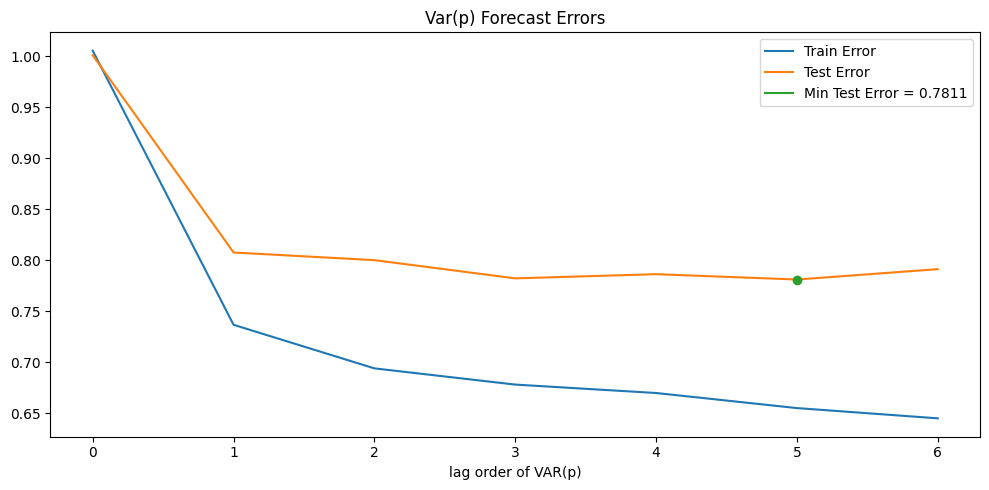

In [49]:
# Plot Errors
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(np.arange(len(out)), out['Train Error'], color="C0")
ax.plot(np.arange(len(out)), out['Test Error'], color="C1")
ax.plot([], [], color="C2")   # dummy for legend labels
argmin = out['Test Error'].argmin()
ax.plot(argmin, out.iloc[argmin]['Test Error'], 'o', color="C2")
ax.set_title(f'Var(p) Forecast Errors')
ax.set_xlabel('lag order of VAR(p)')
ax.legend(['Train Error', 'Test Error',
           f'Min Test Error = {out.iloc[argmin]["Test Error"]:.4f}'],
          loc='upper right')
plt.tight_layout()